In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
df = pd.read_csv('Apple 2009-2024.csv')

# Inspect the first few rows and dataset info
df.head(), df.info(), df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          16 non-null     int64  
 1   EBITDA (millions)             16 non-null     object 
 2   Revenue (millions)            16 non-null     object 
 3   Gross Profit (millions)       16 non-null     object 
 4   Op Income (millions)          16 non-null     object 
 5   Net Income (millions)         16 non-null     object 
 6   EPS                           16 non-null     object 
 7   Shares Outstanding            16 non-null     object 
 8   Year Close Price              16 non-null     float64
 9   Total Assets (millions)       16 non-null     object 
 10  Cash on Hand (millions)       16 non-null     object 
 11  Long Term Debt (millions)     16 non-null     object 
 12  Total Liabilities (millions)  16 non-null     object 
 13  Gross M

(   year EBITDA (millions) Revenue (millions) Gross Profit (millions)  \
 0  2024          $134,661           $391,035                $180,683   
 1  2023          $125,820           $383,285                $169,148   
 2  2022          $130,541           $394,328                $170,782   
 3  2021          $120,233           $365,817                $152,836   
 4  2020           $77,344           $274,515                $104,956   
 
   Op Income (millions) Net Income (millions)    EPS Shares Outstanding  \
 0             $123,216               $93,736  $6.08             15,408   
 1             $114,301               $96,995  $6.13             15,813   
 2             $119,437               $99,803  $6.11             16,326   
 3             $108,949               $94,680  $5.61             16,865   
 4              $66,288               $57,411  $3.28             17,528   
 
    Year Close Price Total Assets (millions) Cash on Hand (millions)  \
 0          243.0400                

In [3]:
def clean_money_columns(df):
    money_cols = [
        'EBITDA (millions)', 'Revenue (millions)', 'Gross Profit (millions)',
        'Op Income (millions)', 'Net Income (millions)', 'Shares Outstanding',
        'Total Assets (millions)', 'Cash on Hand (millions)',
        'Long Term Debt (millions)', 'Total Liabilities (millions)',
        'Employees', 'EPS'
    ]

    for col in money_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(r'[\$,]', '', regex=True)
            .str.replace(r'[^\d.\-]', '', regex=True)
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df


df = clean_money_columns(df)
print(df.dtypes)



year                              int64
EBITDA (millions)                 int64
Revenue (millions)                int64
Gross Profit (millions)           int64
Op Income (millions)              int64
Net Income (millions)             int64
EPS                             float64
Shares Outstanding                int64
Year Close Price                float64
Total Assets (millions)           int64
Cash on Hand (millions)           int64
Long Term Debt (millions)         int64
Total Liabilities (millions)      int64
Gross Margin                     object
PE ratio                        float64
Employees                         int64
dtype: object


In [4]:
def clean_money_and_percentage_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            # Remove $ and commas
            df[col] = df[col].str.replace('$', '', regex=False)
            df[col] = df[col].str.replace(',', '', regex=False)
            # Remove %
            df[col] = df[col].str.replace('%', '', regex=False)
            # Try to convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


In [5]:
def preprocess_data(df):
    df = df.copy()
    df.dropna(inplace=True)
    df = df[df['Year Close Price'] > 0]  # Filter if needed
    return df

In [6]:
df.head()

,year,EBITDA (millions),Revenue (millions),Gross Profit (millions),Op Income (millions),Net Income (millions),EPS,Shares Outstanding,Year Close Price,Total Assets (millions),Cash on Hand (millions),Long Term Debt (millions),Total Liabilities (millions),Gross Margin,PE ratio,Employees
0,2024,134661,391035,180683,123216,93736,6.08,15408,243.0400,364980,65171,85750,308030,46.21%,39.97,164000
1,2023,125820,383285,169148,114301,96995,6.13,15813,191.5919,352583,61555,95281,290437,45.03%,29.84,161000
2,2022,130541,394328,170782,119437,99803,6.11,16326,128.5816,352755,48304,98959,302083,43.06%,21.83,164000
3,2021,120233,365817,152836,108949,94680,5.61,16865,174.7132,351002,62639,109106,287912,43.02%,28.93,154000
4,2020,77344,274515,104956,66288,57411,3.28,17528,129.7556,323888,90943,98667,258549,38.78%,35.14,147000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          16 non-null     int64  
 1   EBITDA (millions)             16 non-null     int64  
 2   Revenue (millions)            16 non-null     int64  
 3   Gross Profit (millions)       16 non-null     int64  
 4   Op Income (millions)          16 non-null     int64  
 5   Net Income (millions)         16 non-null     int64  
 6   EPS                           16 non-null     float64
 7   Shares Outstanding            16 non-null     int64  
 8   Year Close Price              16 non-null     float64
 9   Total Assets (millions)       16 non-null     int64  
 10  Cash on Hand (millions)       16 non-null     int64  
 11  Long Term Debt (millions)     16 non-null     int64  
 12  Total Liabilities (millions)  16 non-null     int64  
 13  Gross M

In [8]:
def plot_eda(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.title("Feature Correlation")
    plt.show()

    # Scatter vs target
    features = [col for col in df.columns if col not in ['year', 'Year Close Price']]
    for col in features:
        sns.scatterplot(x=df[col], y=df['Year Close Price'])
        plt.title(f"{col} vs Close Price")
        plt.xlabel(col)
        plt.ylabel("Close Price")
        plt.show()


In [9]:
def split_data(df):
    X = df.drop(columns=['Year Close Price', 'year'])
    y = df['Year Close Price']
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}\n")
    return preds

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
    }
    
    for name, model in models.items():
        print(f"--- {name} ---")
        model.fit(X_train, y_train)
        preds = evaluate_model(model, X_test, y_test)


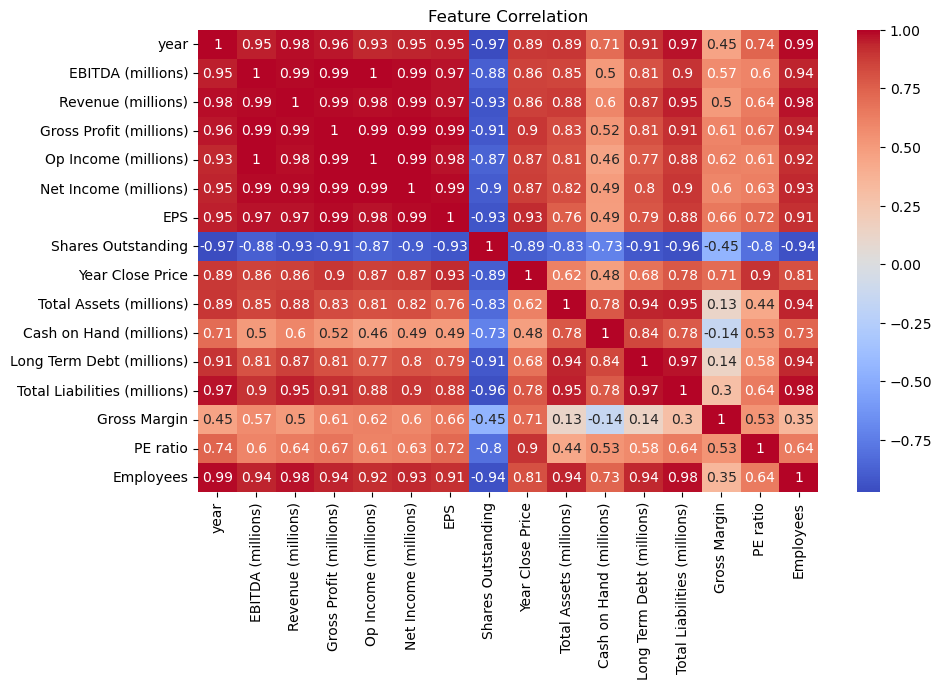

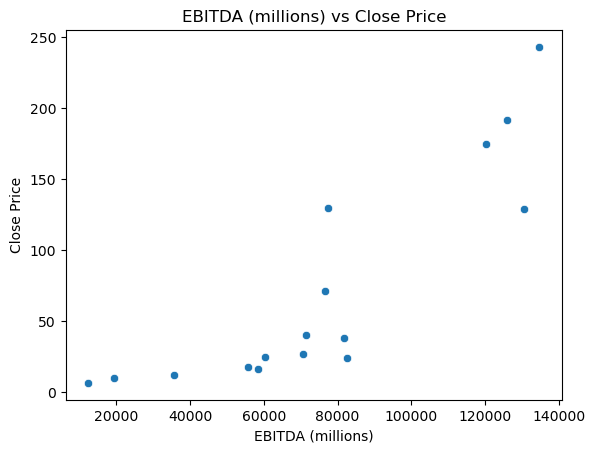

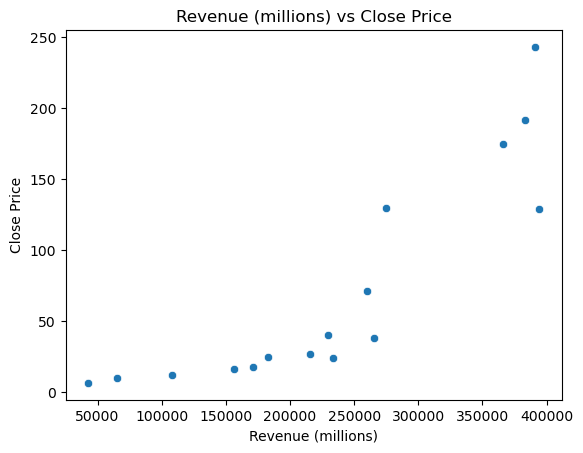

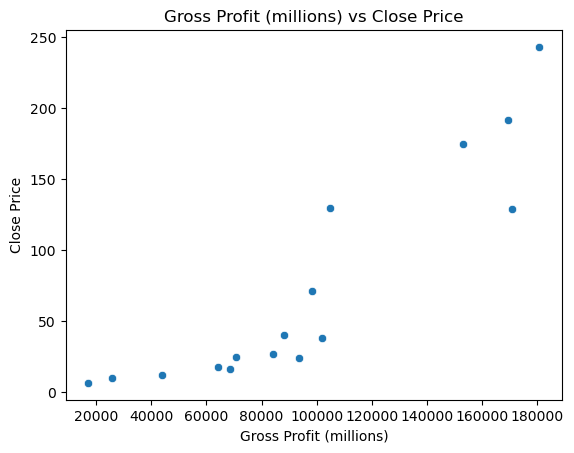

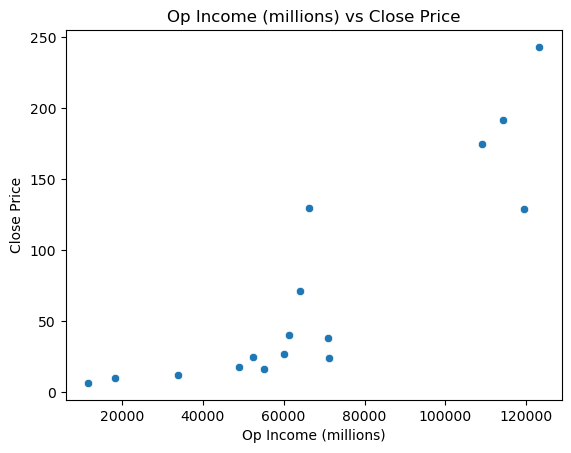

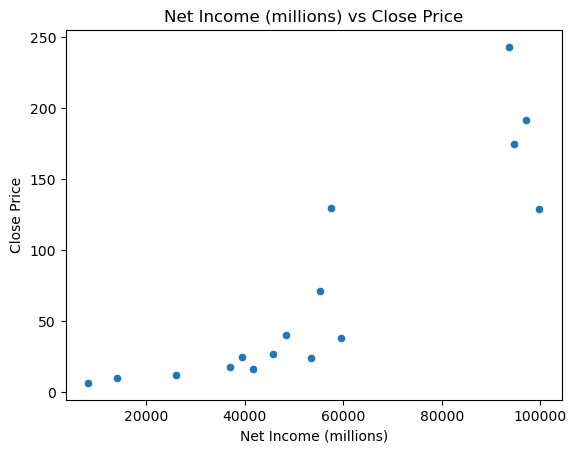

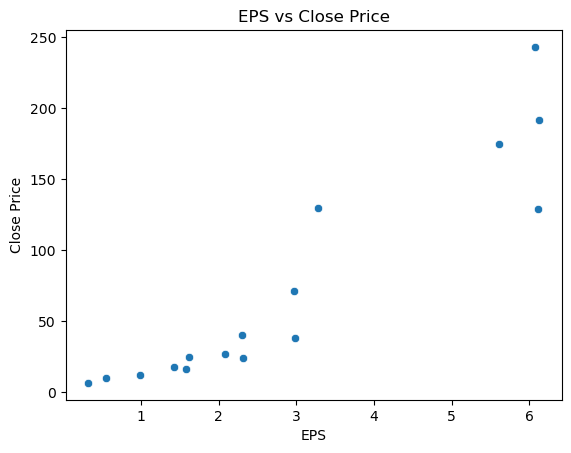

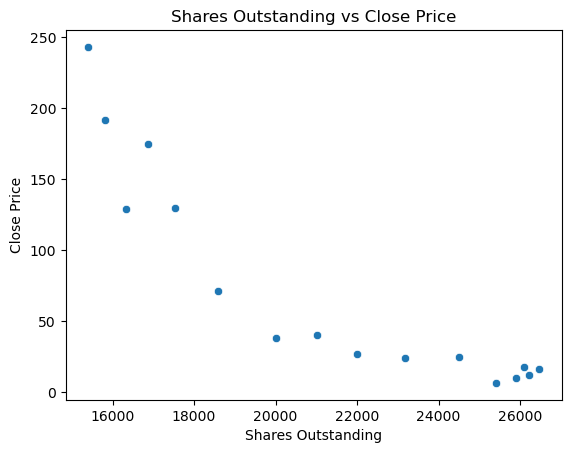

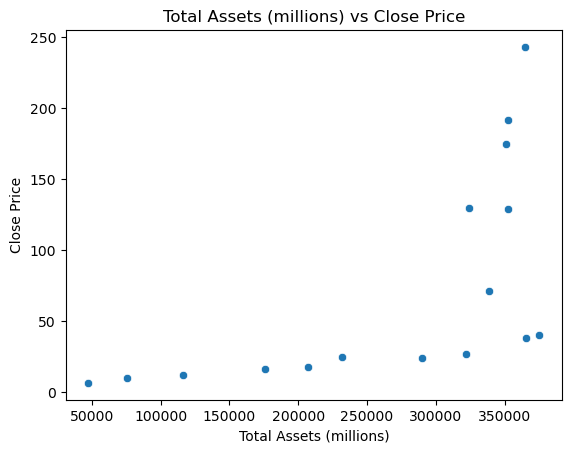

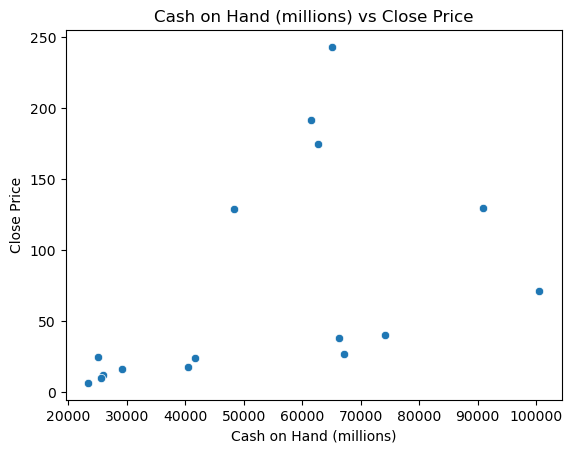

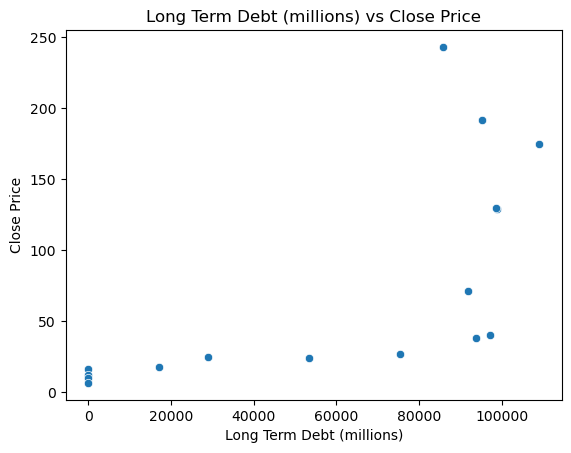

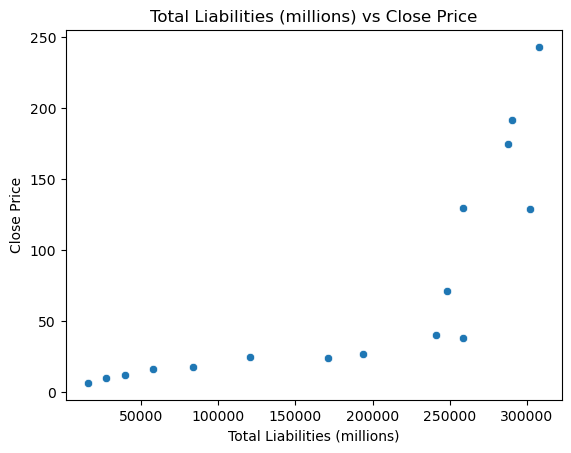

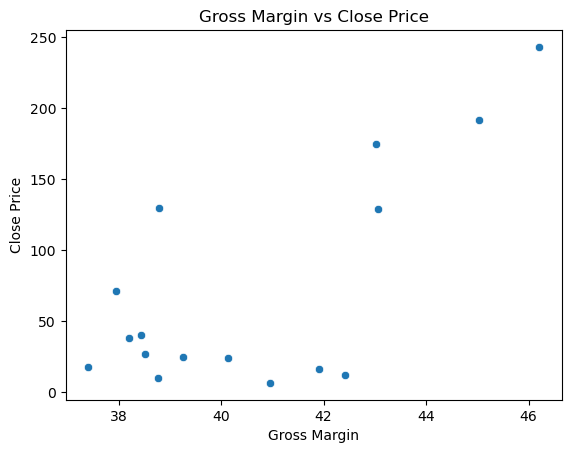

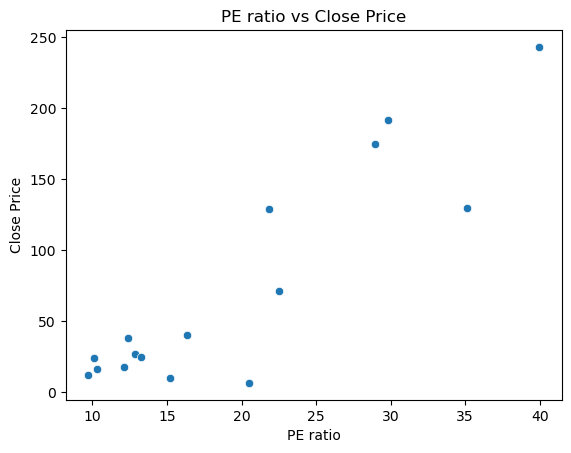

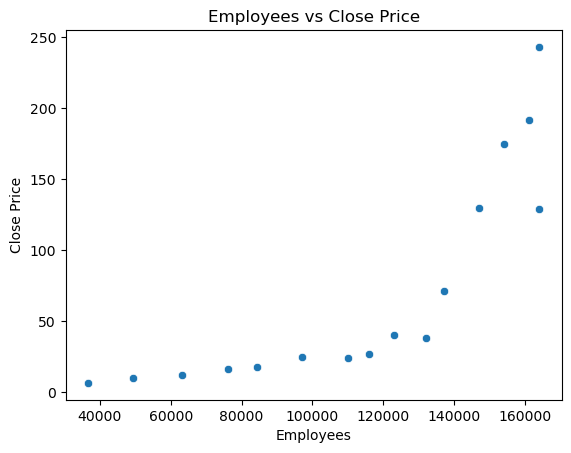

NameError: name 'LinearRegression' is not defined

In [11]:
def main(df):  # take cleaned df as input
    plot_eda(df)

    X_train, X_test, y_train, y_test = split_data(df)
    train_and_evaluate_models(X_train, X_test, y_train, y_test)

if __name__ == '__main__':
    df = pd.read_csv("Apple 2009-2024.csv")
    df = clean_money_and_percentage_columns(df)
    df = preprocess_data(df)  # If needed

    main(df)

In [ ]:
def evaluate(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} MAE: {mae:.2f}")
    print(f"{model_name} RMSE: {rmse:.2f}")
    print(f"{model_name} MAPE: {mape:.2f}%")
    return mae, rmse, mape

In [12]:
# Clean up columns with dollar signs, commas, and percentage signs
def clean_column(col):
    return col.replace({'\$': '', ',': ''}, regex=True).astype(float)

# List of columns to clean
columns_to_clean = ['EBITDA (millions)', 'Revenue (millions)', 'Gross Profit (millions)', 
                    'Op Income (millions)', 'Net Income (millions)', 'Shares Outstanding', 
                    'Year Close Price', 'Total Assets (millions)', 'Cash on Hand (millions)', 
                    'Long Term Debt (millions)', 'Total Liabilities (millions)']

# Apply cleaning function to the selected columns
for col in columns_to_clean:
    df[col] = clean_column(df[col])

# Clean up percentage columns (if any), such as 'Gross Margin'
df['Gross Margin'] = df['Gross Margin'].replace({'%': ''}, regex=True).astype(float)

# Inspect the cleaned dataset
df.head()

,year,EBITDA (millions),Revenue (millions),Gross Profit (millions),Op Income (millions),Net Income (millions),EPS,Shares Outstanding,Year Close Price,Total Assets (millions),Cash on Hand (millions),Long Term Debt (millions),Total Liabilities (millions),Gross Margin,PE ratio,Employees
0,2024,134661.0,391035.0,180683.0,123216.0,93736.0,6.08,15408.0,243.0400,364980.0,65171.0,85750.0,308030.0,46.21,39.97,164000
1,2023,125820.0,383285.0,169148.0,114301.0,96995.0,6.13,15813.0,191.5919,352583.0,61555.0,95281.0,290437.0,45.03,29.84,161000
2,2022,130541.0,394328.0,170782.0,119437.0,99803.0,6.11,16326.0,128.5816,352755.0,48304.0,98959.0,302083.0,43.06,21.83,164000
3,2021,120233.0,365817.0,152836.0,108949.0,94680.0,5.61,16865.0,174.7132,351002.0,62639.0,109106.0,287912.0,43.02,28.93,154000
4,2020,77344.0,274515.0,104956.0,66288.0,57411.0,3.28,17528.0,129.7556,323888.0,90943.0,98667.0,258549.0,38.78,35.14,147000


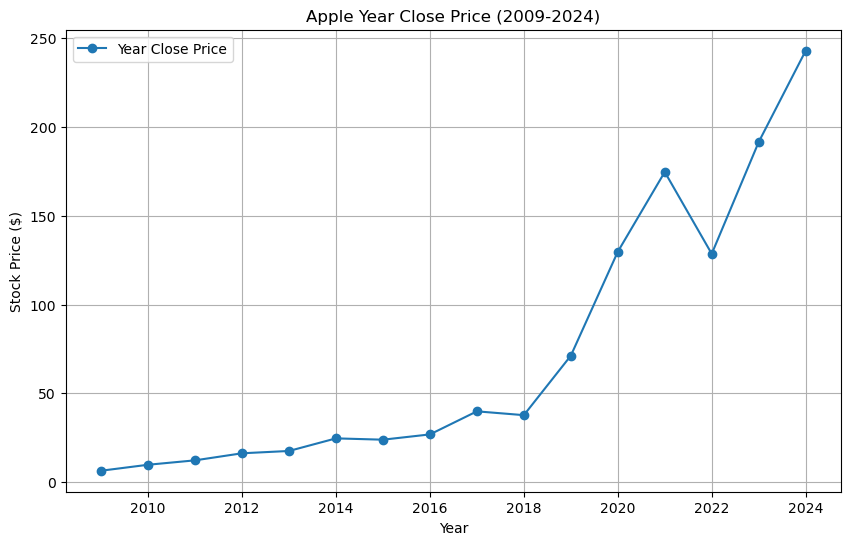

In [13]:
import matplotlib.pyplot as plt

# Plot Year Close Price
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['Year Close Price'], label='Year Close Price', marker='o')
plt.title('Apple Year Close Price (2009-2024)')
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Calculate percentage changes for various financial metrics
df['Revenue_Change'] = df['Revenue (millions)'].pct_change()
df['EBITDA_Change'] = df['EBITDA (millions)'].pct_change()
df['Gross_Profit_Change'] = df['Gross Profit (millions)'].pct_change()

# Check the new columns
df.head()

,year,EBITDA (millions),Revenue (millions),Gross Profit (millions),Op Income (millions),Net Income (millions),EPS,Shares Outstanding,Year Close Price,Total Assets (millions),Cash on Hand (millions),Long Term Debt (millions),Total Liabilities (millions),Gross Margin,PE ratio,Employees,Revenue_Change,EBITDA_Change,Gross_Profit_Change
0,2024,134661.0,391035.0,180683.0,123216.0,93736.0,6.08,15408.0,243.0400,364980.0,65171.0,85750.0,308030.0,46.21,39.97,164000,NaN,NaN,NaN
1,2023,125820.0,383285.0,169148.0,114301.0,96995.0,6.13,15813.0,191.5919,352583.0,61555.0,95281.0,290437.0,45.03,29.84,161000,-0.019819,-0.065654,-0.063841
2,2022,130541.0,394328.0,170782.0,119437.0,99803.0,6.11,16326.0,128.5816,352755.0,48304.0,98959.0,302083.0,43.06,21.83,164000,0.028811,0.037522,0.009660
3,2021,120233.0,365817.0,152836.0,108949.0,94680.0,5.61,16865.0,174.7132,351002.0,62639.0,109106.0,287912.0,43.02,28.93,154000,-0.072303,-0.078964,-0.105081
4,2020,77344.0,274515.0,104956.0,66288.0,57411.0,3.28,17528.0,129.7556,323888.0,90943.0,98667.0,258549.0,38.78,35.14,147000,-0.249584,-0.356716,-0.313277


In [15]:

df = df.sort_values('year').set_index('year')

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [16]:
print(train.columns)
print(train.index)

Index(['EBITDA (millions)', 'Revenue (millions)', 'Gross Profit (millions)',
       'Op Income (millions)', 'Net Income (millions)', 'EPS',
       'Shares Outstanding', 'Year Close Price', 'Total Assets (millions)',
       'Cash on Hand (millions)', 'Long Term Debt (millions)',
       'Total Liabilities (millions)', 'Gross Margin', 'PE ratio', 'Employees',
       'Revenue_Change', 'EBITDA_Change', 'Gross_Profit_Change'],
      dtype='object')
Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype='int64', name='year')


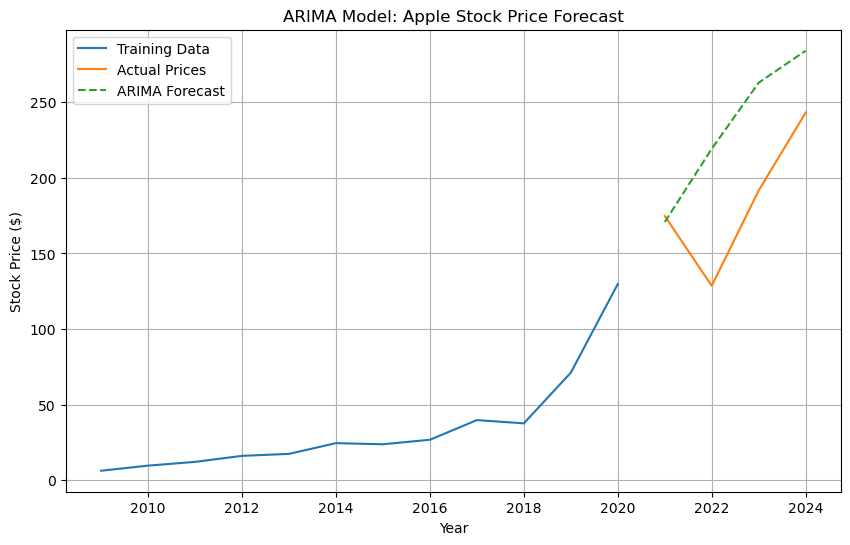

In [17]:
from statsmodels.tsa.arima.model import ARIMA

train = train.reset_index()
test = test.reset_index()

model_arima = ARIMA(train['Year Close Price'], order=(5, 1, 0))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train['year'], train['Year Close Price'], label='Training Data')
plt.plot(test['year'], test['Year Close Price'], label='Actual Prices')
plt.plot(test['year'], forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Model: Apple Stock Price Forecast')
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, RMSE
mae = mean_absolute_error(test['Year Close Price'], forecast_arima)
rmse = np.sqrt(mean_squared_error(test['Year Close Price'], forecast_arima))

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test['Year Close Price'] - forecast_arima) / test['Year Close Price'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 51.67
RMSE: 61.16
MAPE: nan%
